<a href="https://colab.research.google.com/github/asgharlaib/Project_v1/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --upgrade adapt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 932.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 67.8 MB/s eta 0:00:00
  Created wheel for adapt: filename=adapt-0.4.4-py3-none-any.whl size=131790 sha256=7d4d7bb34154a0c75bef7ba1a9096cd7f094eff9d50f7cc06fd9191ff4088634
  Stored in directory: /root/.cache/pip/wheels/cb/88/91/f7ac7b6024ad8778b5ecca6ebe44421105722648f2a6b7afd7
Successfully built adapt
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [2]:
pip install keras --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [3]:
!pip install prophet

In [4]:
#Importing necessary libraries
import pandas as pd
import scikeras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from prophet import Prophet
from scikeras.wrappers import KerasRegressor
import os
from statsmodels.tsa.arima_model import ARIMA

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#reading the dataset
full_df = pd.read_csv("/content/drive/MyDrive/CC_LCL-FullData.csv")
full_df.head(n=10)

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0
5,MAC000002,Std,2012-10-12 03:00:00.0000000,0
6,MAC000002,Std,2012-10-12 03:30:00.0000000,0
7,MAC000002,Std,2012-10-12 04:00:00.0000000,0
8,MAC000002,Std,2012-10-12 04:30:00.0000000,0
9,MAC000002,Std,2012-10-12 05:00:00.0000000,0


In [7]:
#Making copy of origonal dataset
full_df_copy = full_df.copy()

In [26]:
print(f"full_df columns datatypes: {full_df.dtypes}")

full_df columns datatypes: LCLid                       object
stdorToU                    object
KWH/hh (per half hour)     float64
Date                        object
Time                        object
dtype: object


In [9]:
# Convert the 'DateTime' column to datetime type
full_df['DateTime'] = pd.to_datetime(full_df['DateTime'])


# Extract the date and time into separate columns
full_df['Date'] = full_df['DateTime'].dt.date
full_df['Time'] = full_df['DateTime'].dt.time


# Display the first few rows to verify
print(full_df.head())

       LCLid stdorToU            DateTime KWH/hh (per half hour)         Date  \
0  MAC000002      Std 2012-10-12 00:30:00                      0   2012-10-12   
1  MAC000002      Std 2012-10-12 01:00:00                      0   2012-10-12   
2  MAC000002      Std 2012-10-12 01:30:00                      0   2012-10-12   
3  MAC000002      Std 2012-10-12 02:00:00                      0   2012-10-12   
4  MAC000002      Std 2012-10-12 02:30:00                      0   2012-10-12   

       Time  
0  00:30:00  
1  01:00:00  
2  01:30:00  
3  02:00:00  
4  02:30:00  


In [10]:
full_df.set_index('DateTime', inplace=True)

In [11]:
#Converting consumption column to numeric datatype
full_df['KWH/hh (per half hour) '] = pd.to_numeric(full_df['KWH/hh (per half hour) '], errors='coerce')
full_df.columns

Index(['LCLid', 'stdorToU', 'KWH/hh (per half hour) ', 'Date', 'Time'], dtype='object')

In [12]:
#Pre-processing for creating daily dataframe
full_df_daily = full_df.groupby(['LCLid','stdorToU', 'Date']).agg({'KWH/hh (per half hour) ': 'sum'}).reset_index()
full_df_daily.rename(columns={'KWH/hh (per half hour) ': 'Daily KWH'}, inplace=True)
full_df_daily.head(20)

,Date,stdorToU,LCLid,Daily KWH
0,2011-11-23,Std,MAC000145,8.952
1,2011-11-23,Std,MAC000148,1.283
2,2011-11-23,Std,MAC000149,2.287
3,2011-11-23,Std,MAC000150,9.254
4,2011-11-23,Std,MAC000151,3.273
5,2011-11-23,Std,MAC000152,5.969
6,2011-11-23,Std,MAC000153,21.702
7,2011-11-23,Std,MAC000154,5.798
8,2011-11-23,Std,MAC000155,9.281
9,2011-11-23,Std,MAC000156,6.523


In [ ]:
#Locating nan indices
nan_indices = full_df_daily[full_df_daily['Daily KWH'].isnull()].index
print(nan_indices)

Index([], dtype='int64')


In [ ]:
#Dealing with nan values
full_df_daily['Daily KWH'].fillna(full_df_daily['Daily KWH'].mean(skipna=True), inplace=True)
full_df_daily.head(15)

,Date,stdorToU,LCLid,Daily KWH
0,2011-11-23,ToU,MAC000146,5.619
1,2011-11-24,ToU,MAC000146,8.564
2,2011-11-25,ToU,MAC000146,6.743
3,2011-11-26,ToU,MAC000146,6.029
4,2011-11-27,ToU,MAC000146,5.740
5,2011-11-28,ToU,MAC000146,6.096
6,2011-11-29,ToU,MAC000146,7.121
7,2011-11-30,ToU,MAC000146,6.612
8,2011-12-01,ToU,MAC000146,6.002
9,2011-12-02,ToU,MAC000146,5.309


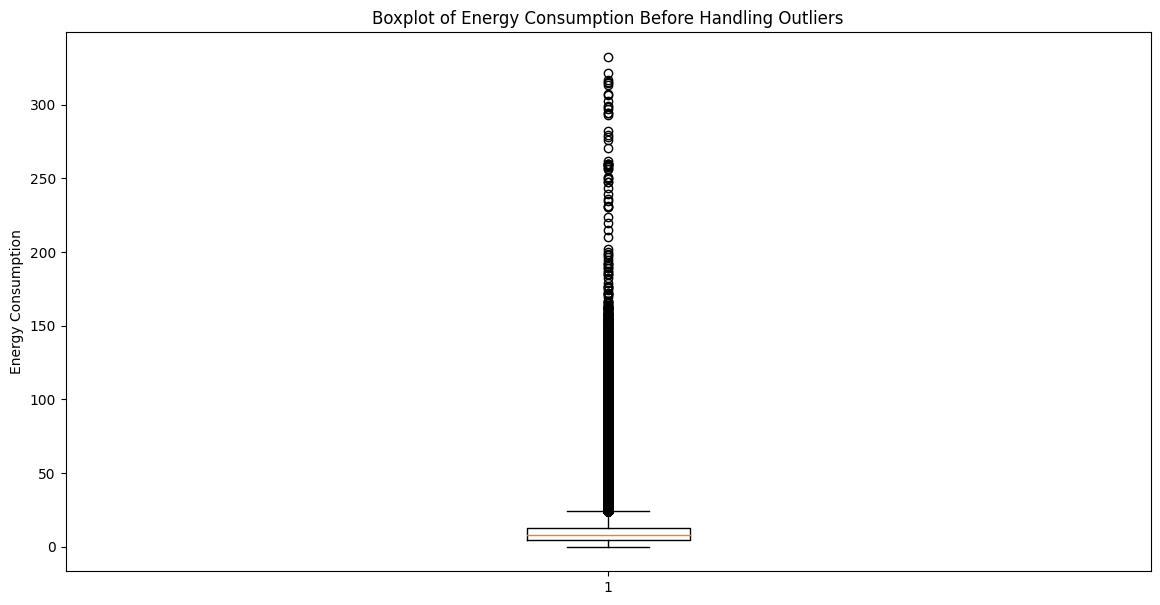

In [15]:
plt.figure(figsize=(14, 7))

plt.boxplot(full_df_daily['Daily KWH'])
plt.title('Boxplot of Energy Consumption Before Handling Outliers')
plt.ylabel('Energy Consumption')
plt.savefig('Outliers_Boxplot before.png')
plt.show()

In [16]:
quantile1 = full_df_daily['Daily KWH'].quantile(0.25)
quantile3 = full_df_daily['Daily KWH'].quantile(0.75)
Inter_quartile_range = quantile3 - quantile1
lower_bound = quantile1 - 1.5 * Inter_quartile_range
upper_bound = quantile3 + 1.5 * Inter_quartile_range

In [17]:
filtered_data = full_df_daily[(full_df_daily['Daily KWH'] >= lower_bound) &
                              (full_df_daily['Daily KWH'] <= upper_bound)]
filtered_data.head(10)

,Date,stdorToU,LCLid,Daily KWH
0,2011-11-23,Std,MAC000145,8.952
1,2011-11-23,Std,MAC000148,1.283
2,2011-11-23,Std,MAC000149,2.287
3,2011-11-23,Std,MAC000150,9.254
4,2011-11-23,Std,MAC000151,3.273
5,2011-11-23,Std,MAC000152,5.969
6,2011-11-23,Std,MAC000153,21.702
7,2011-11-23,Std,MAC000154,5.798
8,2011-11-23,Std,MAC000155,9.281
9,2011-11-23,Std,MAC000156,6.523


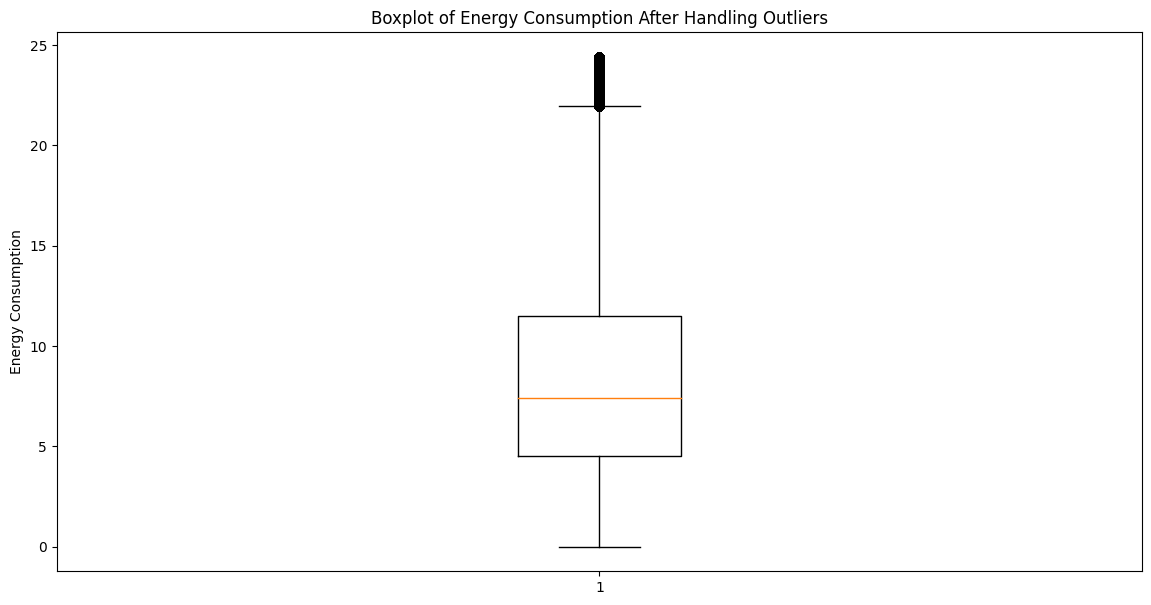

In [18]:
plt.figure(figsize=(14, 7))

plt.boxplot(filtered_data['Daily KWH'])
plt.title('Boxplot of Energy Consumption After Handling Outliers')
plt.ylabel('Energy Consumption')
plt.savefig('Outliers_Subplot after.png')
plt.show()



In [ ]:
#Looking for missing values
print(f"missing values: {full_df_daily.isnull().sum()} \n")

missing values: Date         0
stdorToU     0
LCLid        0
Daily KWH    0
dtype: int64 



In [13]:
##Descriptive Analysis
#Dataframe column names
print(f"Column names: {list(full_df_daily.columns)} \n")

#Dataframe shape
print(f"full_df_daily shape: {full_df_daily.shape} \n")

#Dataframe datatypes
print(f"full_df_daily columns datatypes: {full_df_daily.dtypes} \n")

#Looking for missing values
print(f"missing values: {full_df_daily.isnull().sum()} \n")

Column names: ['Date', 'stdorToU', 'LCLid', 'Daily KWH'] 

full_df_daily shape: (3510433, 4) 

full_df_daily columns datatypes: Date          object
stdorToU      object
LCLid         object
Daily KWH    float64
dtype: object 

missing values: Date         0
stdorToU     0
LCLid        0
Daily KWH    0
dtype: int64 



In [14]:
##Descriptive Statistics
full_df_daily.describe()

,Daily KWH
count,3.510433e+06
mean,1.013001e+01
std,9.134486e+00
min,0.000000e+00
25%,4.685000e+00
50%,7.819000e+00
75%,1.257600e+01
max,3.325560e+02


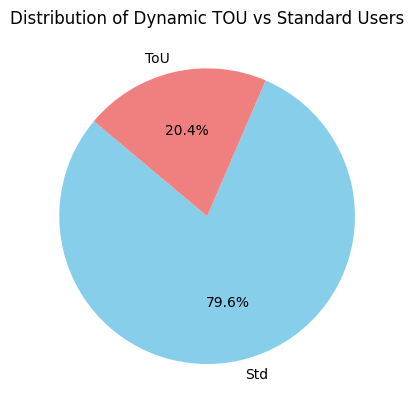

In [19]:
# Count the occurrences of each category
counts = filtered_data['stdorToU'].value_counts()

# Plot a pie chart
plt.figure()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Dynamic TOU vs Standard Users')
plt.show()


         Date stdorToU      LCLid  Daily KWH
0  2011-11-23      Std  MAC000145      8.952
1  2011-11-23      Std  MAC000148      1.283
2  2011-11-23      Std  MAC000149      2.287
3  2011-11-23      Std  MAC000150      9.254
4  2011-11-23      Std  MAC000151      3.273
          Date stdorToU      LCLid  Daily KWH
11  2011-11-23      ToU  MAC000146      5.619
12  2011-11-23      ToU  MAC000147      3.036
34  2011-11-24      ToU  MAC000146      8.564
35  2011-11-24      ToU  MAC000147      7.489
36  2011-11-24      ToU  MAC000158      3.181


<ipython-input-20-0524518c5ac2>:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


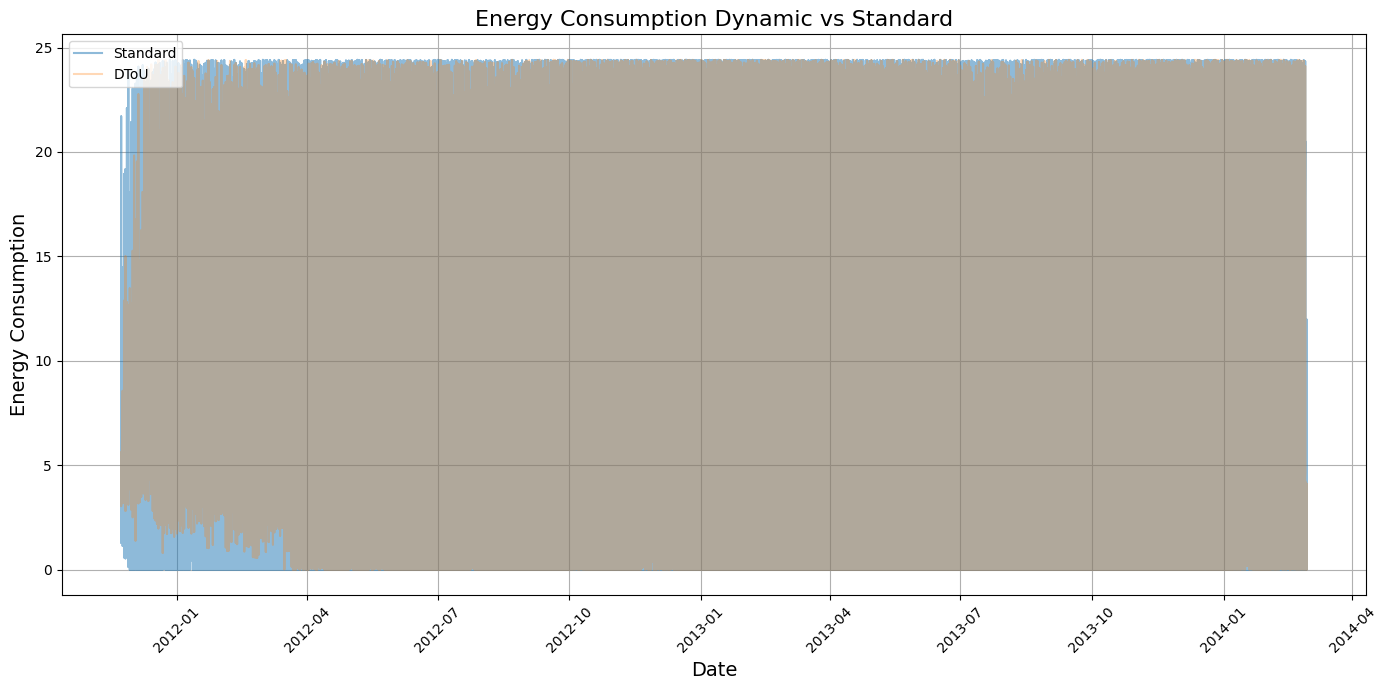

In [20]:
# Filter for dynamic and standard pricing
df_standard = filtered_data[filtered_data['stdorToU'] == 'Std']
df_dynamic = filtered_data[filtered_data['stdorToU'] == 'ToU']

print(df_standard.head())
print(df_dynamic.head())
# Plot the data
plt.figure(figsize=(14, 7))
#plt.hist(df_dynamic['KWH/hh (per half hour) '], bins=20, alpha=0.5, color = 'b', label='Dynamic')
#plt.hist(df_standard['KWH/hh (per half hour) '], bins=20, alpha=0.5, color = 'r', label='Standard')
plt.plot(df_standard['Date'], df_standard['Daily KWH'],alpha = 0.5, label='Standard')
plt.plot(df_dynamic['Date'], df_dynamic['Daily KWH'],alpha= 0.3, label='DToU')
# Formatting the plot
plt.title('Energy Consumption Dynamic vs Standard', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Energy Consumption', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [21]:
def preprocess_data(df, time_step):
    data = df['Daily KWH'].values
    dates = df['Date'].values  # Using 'Date' column
    data = data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    X, y, datestamps = [], [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
        datestamps.append(dates[i + time_step])  # Store corresponding date
    X = np.array(X)
    y = np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    datestamps = np.array(datestamps)  # Convert list to numpy array
    return X, y, scaler, datestamps


In [ ]:
# Check for NaNs in the input data for the standard users
if df_standard.isnull().values.any():
    print("NaN values found in the input data for standard users.")
else:
    print("No NaN values in the input data for standard users.")


No NaN values in the input data for standard users.


In [22]:
# Preprocess the data
time_step = 8  # number of previous timesteps to use for prediction
X_dynamic, y_dynamic, scaler_dynamic, date_stamps_dynamic = preprocess_data(df_dynamic, time_step)
X_standard, y_standard, scaler_standard, date_stamps_standard = preprocess_data(df_standard, time_step)

# Split the data into training and testing sets
X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(X_dynamic, y_dynamic, test_size=0.2, random_state=42)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_standard, y_standard, test_size=0.2, random_state=42)

In [23]:
# Build LSTM model
def build_lstm_model(input_shape, units=50, dropout_rate=0.2, learning_rate=0.001):
    print(f"Building LSTM model with input shape: {input_shape}")
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


In [24]:
# Train the LSTM model for dynamic users
model_dynamic = build_lstm_model(input_shape=(X_train_dyn.shape[1], X_train_dyn.shape[2]))
history_dynamic = model_dynamic.fit(X_train_dyn, y_train_dyn, epochs=20, batch_size=32, validation_data=(X_test_dyn, y_test_dyn), verbose=1)


Building LSTM model with input shape: (8, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
16849/16849 ━━━━━━━━━━━━━━━━━━━━ 98s 6ms/step - loss: 0.0431 - val_loss: 0.0429
Epoch 2/20
16849/16849 ━━━━━━━━━━━━━━━━━━━━ 93s 6ms/step - loss: 0.0425 - val_loss: 0.0421
Epoch 3/20
16849/16849 ━━━━━━━━━━━━━━━━━━━━ 96s 6ms/step - loss: 0.0424 - val_loss: 0.0421
Epoch 4/20
16849/16849 ━━━━━━━━━━━━━━━━━━━━ 109s 6ms/step - loss: 0.0422 - val_loss: 0.0417
Epoch 5/20
16849/16849 ━━━━━━━━━━━━━━━━━━━━ 102s 6ms/step - loss: 0.0419 - val_loss: 0.0413
Epoch 6/20
16849/16849 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - loss: 0.0414 - val_loss: 0.0407
Epoch 7/20
16849/16849 ━━━━━━━━━━━━━━━━━━━━ 95s 6ms/step - loss: 0.0409 - val_loss: 0.0399
Epoch 8/20
16849/16849 ━━━━━━━━━━━━━━━━━━━━ 96s 6ms/step - loss: 0.0403 - val_loss: 0.0396
Epoch 9/20
16849/16849 ━━━━━━━━━━━━━━━━━━━━ 96s 6ms/step - loss: 0.0399 - val_loss: 0.0394
Epoch 10/20
16849/16849 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - loss: 0.0394 - val_loss: 0.0388
Epoch 11/20
16849/16849 ━━━━━━━━━━━━━━━━━━━━ 92s 5ms/step - loss: 0.0392 - val_loss: 0.

In [27]:
# Train the LSTM model for standard users
model_standard = build_lstm_model(input_shape=(X_train_std.shape[1], X_train_std.shape[2]))
history_standard = model_standard.fit(X_train_std, y_train_std, epochs=20, batch_size=32, validation_data=(X_test_std, y_test_std), verbose=1)


Building LSTM model with input shape: (8, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
65873/65873 ━━━━━━━━━━━━━━━━━━━━ 361s 5ms/step - loss: 0.0459 - val_loss: 0.0456
Epoch 2/20
65873/65873 ━━━━━━━━━━━━━━━━━━━━ 360s 5ms/step - loss: 0.0455 - val_loss: 0.0454
Epoch 3/20
65873/65873 ━━━━━━━━━━━━━━━━━━━━ 361s 5ms/step - loss: 0.0453 - val_loss: 0.0451
Epoch 4/20
65873/65873 ━━━━━━━━━━━━━━━━━━━━ 363s 6ms/step - loss: 0.0450 - val_loss: 0.0449
Epoch 5/20
65873/65873 ━━━━━━━━━━━━━━━━━━━━ 365s 6ms/step - loss: 0.0448 - val_loss: 0.0447
Epoch 6/20
65873/65873 ━━━━━━━━━━━━━━━━━━━━ 364s 6ms/step - loss: 0.0448 - val_loss: 0.0445
Epoch 7/20
65873/65873 ━━━━━━━━━━━━━━━━━━━━ 368s 6ms/step - loss: 0.0445 - val_loss: 0.0445
Epoch 8/20
65873/65873 ━━━━━━━━━━━━━━━━━━━━ 364s 6ms/step - loss: 0.0444 - val_loss: 0.0441
Epoch 9/20
65873/65873 ━━━━━━━━━━━━━━━━━━━━ 365s 6ms/step - loss: 0.0442 - val_loss: 0.0440
Epoch 10/20
65873/65873 ━━━━━━━━━━━━━━━━━━━━ 364s 6ms/step - loss: 0.0441 - val_loss: 0.0439
Epoch 11/20
65873/65873 ━━━━━━━━━━━━━━━━━━━━ 366s 6ms/step - loss: 0.0440 - val

In [28]:
# Predict consumption for dynamic users
pred_dynamic = model_dynamic.predict(X_test_dyn)

# Predict consumption for standard users
pred_standard = model_standard.predict(X_test_std)

4213/4213 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
16469/16469 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step


In [ ]:
# Check for NaNs in the predictions
if np.any(np.isnan(pred_standard)):
    print("NaN values found in standard TOU predictions.")
else:
    print("No NaN values in standard TOU predictions.")


No NaN values in standard TOU predictions.


In [29]:
# Inverse transform the predictions for dynamic users
pred_dynamic = scaler_dynamic.inverse_transform(pred_dynamic)
y_test_dyn_inverse = scaler_dynamic.inverse_transform(y_test_dyn.reshape(-1, 1))

# Inverse transform the predictions for standard users
pred_standard = scaler_standard.inverse_transform(pred_standard)
y_test_std_inverse = scaler_standard.inverse_transform(y_test_std.reshape(-1, 1))

In [30]:
# Find peak consumption values for dynamic users
peak_dynamic_value = max(pred_dynamic)
peak_dynamic_time = y_test_dyn_inverse[np.argmax(pred_dynamic)]

# Find peak consumption values for standard users
peak_standard_value = max(pred_standard)
peak_standard_time = y_test_std_inverse[np.argmax(pred_standard)]


In [31]:
print(f"Peak Dynamic TOU Consumption Value: {peak_dynamic_value}")
print(f"Corresponding Actual Dynamic TOU Consumption Value: {peak_dynamic_time}")

print(f"Peak Standard Consumption Value: {peak_standard_value}")
print(f"Corresponding Actual Standard TOU Consumption Value: {peak_standard_time}")


Peak Dynamic TOU Consumption Value: [21.131023]
Corresponding Actual Dynamic TOU Consumption Value: [22.235]
Peak Standard Consumption Value: [21.089897]
Corresponding Actual Standard TOU Consumption Value: [23.554]


In [32]:
# Calculate MAE for dynamic users
mae_dynamic = mean_absolute_error(y_test_dyn_inverse, pred_dynamic)
print(f"Dynamic TOU MAE: {mae_dynamic}")

# Calculate MAE for standard users
mae_standard = mean_absolute_error(y_test_std_inverse, pred_standard)
print(f"Standard TOU MAE: {mae_standard}")


Dynamic TOU MAE: 3.6697385415736408
Standard TOU MAE: 4.033721544295756


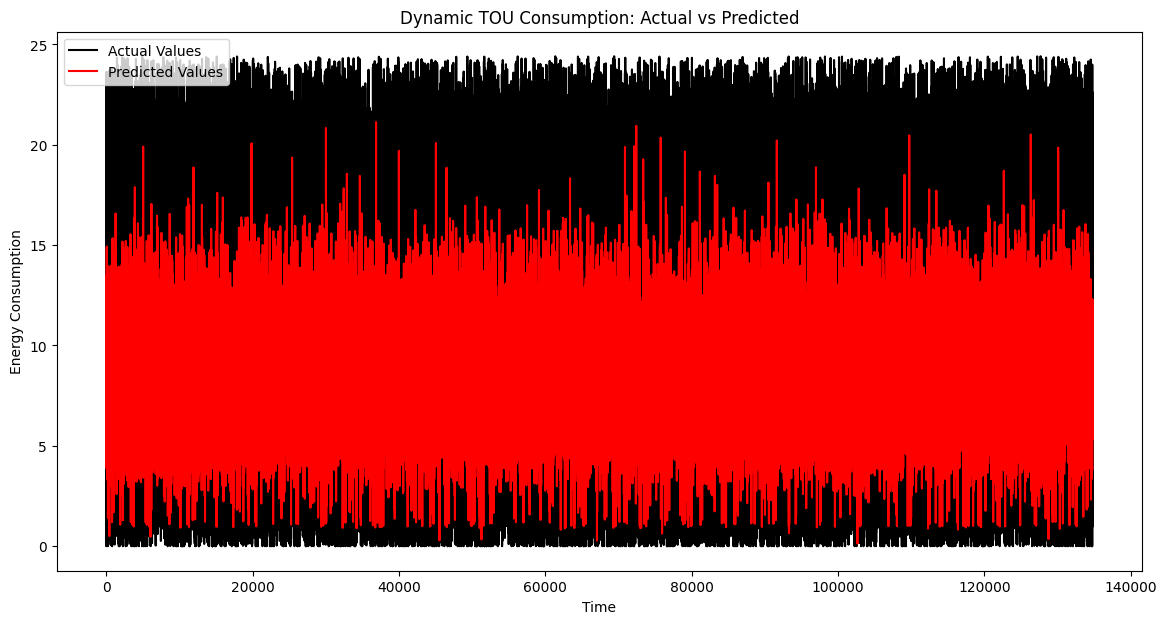

In [33]:
# Plot the predictions vs actual values for dynamic TOU users
plt.figure(figsize=(14, 7))
plt.plot(y_test_dyn_inverse, color='black', label='Actual Values')
plt.plot(pred_dynamic, color='red', label='Predicted Values')
plt.title('Dynamic TOU Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()




In [34]:
model = KerasRegressor(build_fn=build_lstm_model, input_shape = (8,1), epochs=1, batch_size=32, verbose=0, dropout_rate=0.2, learning_rate=0.001, units=50)

In [ ]:
param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train_dyn, y_train_dyn)

# Print the best parameters and score
print(f"Best parameters found: {grid_result.best_params_}")
print(f"Best score found: {grid_result.best_score_}")


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
# Build LSTM model
def best_grid_lstm_model(input_shape, units=100, dropout_rate=0.2, learning_rate=0.01):
    print(f"Building LSTM model with input shape: {input_shape}")
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [ ]:
best_model_dynamic = best_grid_lstm_model(input_shape=(X_train_dyn.shape[1], X_train_dyn.shape[2]))
history_best_dynamic = best_model_dynamic.fit(X_train_dyn, y_train_dyn, epochs=20, batch_size=32, validation_data=(X_test_dyn, y_test_dyn), verbose=1)

Building LSTM model with input shape: (8, 1)
Epoch 1/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0517 - val_loss: 0.0414
Epoch 2/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0420 - val_loss: 0.0392
Epoch 3/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0394 - val_loss: 0.0351
Epoch 4/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0360 - val_loss: 0.0340
Epoch 5/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0343 - val_loss: 0.0325
Epoch 6/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0327 - val_loss: 0.0311
Epoch 7/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0304 - val_loss: 0.0306
Epoch 8/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0293 - val_loss: 0.0296
Epoch 9/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0283 - val_loss: 0.0285
Epoch 10/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0279 - val_loss: 0.0281
Epoch 11/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0273 - val_loss: 0.0281
Epoch 1

In [ ]:

best_model_standard = best_grid_lstm_model(input_shape=(X_train_std.shape[1], X_train_std.shape[2]))
history_best_standard = best_model_standard.fit(X_train_std, y_train_std, epochs=20, batch_size=32, validation_data=(X_test_std, y_test_std), verbose=1)

Building LSTM model with input shape: (8, 1)
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0466 - val_loss: 0.0218
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0230 - val_loss: 0.0213
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0248 - val_loss: 0.0216
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0204 - val_loss: 0.0191
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0207 - val_loss: 0.0196
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0196 - val_loss: 0.0184
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0214 - val_loss: 0.0181
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0196 - val_loss: 0.0174
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0183 - val_loss: 0.0176
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0202 - val_loss: 0.0182
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0172 - val_loss: 0.0182
Epoch 12/20
75/75 ━━━━━━━━━

In [25]:
# Predict consumption for dynamic users
pred_dynamic1 = best_model_dynamic.predict(X_test_dyn)

# Predict consumption for standard users
pred_standard1 = best_model_standard.predict(X_test_std)

NameError: name 'best_model_dynamic' is not defined

In [ ]:
# Inverse transform the predictions for dynamic users
pred_dynamic1 = scaler_dynamic.inverse_transform(pred_dynamic1)
y_test_dyn_inverse = scaler_dynamic.inverse_transform(y_test_dyn.reshape(-1, 1))

# Inverse transform the predictions for standard users
pred_standard1 = scaler_standard.inverse_transform(pred_standard1)
y_test_std_inverse = scaler_standard.inverse_transform(y_test_std.reshape(-1, 1))

In [ ]:
# Calculate MAE for dynamic users
mae_dynamic = mean_absolute_error(y_test_dyn_inverse, pred_dynamic1)
print(f"Dynamic TOU MAE: {mae_dynamic}")

# Calculate MAE for standard users
mae_standard = mean_absolute_error(y_test_std_inverse, pred_standard1)
print(f"Standard TOU MAE: {mae_standard}")


Dynamic TOU MAE: 3.2024750948117724
Standard TOU MAE: 2.36961667018746


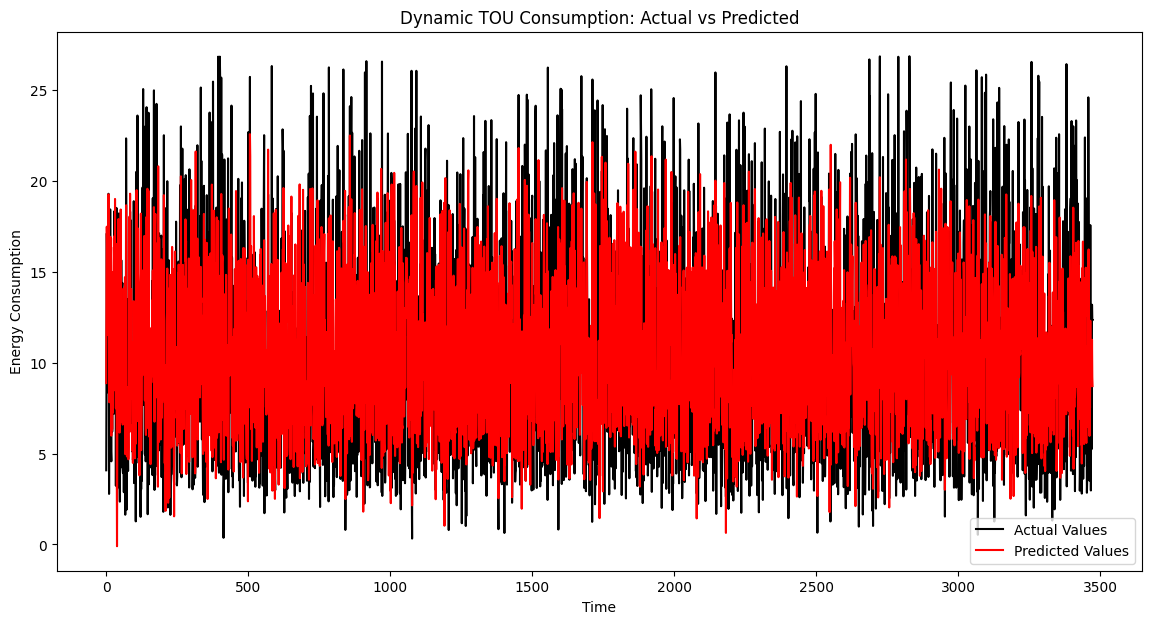

In [ ]:
# Plot the predictions vs actual values for dynamic TOU users
plt.figure(figsize=(14, 7))
plt.plot(y_test_dyn_inverse, color='black', label='Actual Values')
plt.plot(pred_dynamic1, color='red', label='Predicted Values')
plt.title('Dynamic TOU Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

In [ ]:
df_prophet_dynamic = df_dynamic[['Date', 'Daily KWH']].rename(columns={'Date': 'ds', 'KWH/hh (per half hour) ': 'y'})

In [ ]:
train_size_dynamic = int(len(df_prophet_dynamic) * 0.8)
train_data_dynamic = df_prophet_dynamic[:train_size_dynamic]
test_data_dynamic = df_prophet_dynamic[train_size_dynamic:]

In [ ]:
model_dynamic = Prophet()
model_dynamic.fit(train_data_dynamic)

In [ ]:
future_dynamic = model_dynamic.make_future_dataframe(periods=len(test_data_dynamic), freq='D')  # 'H' for hourly data
forecast_dynamic = model_dynamic.predict(future_dynamic)

In [ ]:
forecast_test_dynamic = forecast_dynamic.iloc[-len(test_data_dynamic):]['yhat']
mse = mean_squared_error(test_data_dynamic['y'], forecast_test_dynamic)
print(f'Mean Squared Error: {mse}')

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_data_dynamic['ds'], test_data_dynamic['y'], label='Actual Values')
plt.plot(test_data_dynamic['ds'], forecast_test_dynamic, label='Forecasted Values')
plt.legend(loc='upper left')
plt.title('Dynamic Peak Hour Forecast vs Actual')
plt.show()

In [ ]:
df_prophet_std = df_standard[['Date', 'Daily KWH']].rename(columns={'Date': 'ds', 'KWH/hh (per half hour) ': 'y'})

In [ ]:
train_size_std = int(len(df_prophet_std) * 0.8)
train_data_std = df_prophet_std[:train_size_std]
test_data_std = df_prophet_std[train_size_std:]
print(test_data_std)

In [ ]:
model_std = Prophet()
model_std.fit(train_data_std)

In [ ]:
test_data_std = test_data_std.dropna(subset=['y'])

In [ ]:
test_data_std['y'].fillna(method='ffill', inplace=True)  # forward fill

In [ ]:
print(test_data_std[test_data_std['y'].isna()])

In [ ]:
future_std = model_std.make_future_dataframe(periods=len(test_data_std), freq='D')  # 'H' for hourly data
forecast_std = model_std.predict(future_std)

In [ ]:
forecast_test_std = forecast_std.iloc[-len(test_data_std):]['yhat']
mse = mean_squared_error(test_data_std['y'], forecast_test_std)
print(f'Mean Squared Error: {mse}')

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_data_std['ds'], test_data_std['y'], label='Actual Values')
plt.plot(test_data_std['ds'], forecast_test_std, label='Forecasted Values')
plt.legend(loc='upper left')
plt.title('Standard Peak Hour Forecast vs Actual')
plt.show()

In [ ]:
# Find the maximum predicted consumption
max_predicted_value = forecast_dynamic['yhat'].max()
# Find the maximum predicted consumption
max_predicted_value = forecast_std['yhat'].max()

# Print the results
print(f"The maximum predicted dynamic consumption is {max_predicted_value:.2f} KWH")
print(f"The maximum predicted standard consumption is {max_predicted_value:.2f} KWH")

In [ ]:
import itertools

# Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [10.0, 15.0, 20.0],
    'holidays_prior_scale': [0.1, 0.5, 1.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Initialize a DataFrame to store the results
results = []

# Loop over each combination of parameters
for params in all_params:
    # Initialize a Prophet model with the current set of parameters
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale']
    )

     # Fit the model on the training data
    model.fit(train_data_dynamic)

    # Make predictions on the test data
    forecast = model.predict(test_data_dynamic)

    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(test_data_dynamic['y'], forecast['yhat'])

    # Store the parameters and the mse in the results list
    results.append({'params': params, 'mse': mse})

# Convert the results list into a DataFrame
results_df = pd.DataFrame(results)

# Find the parameters with the lowest mse
best_params = results_df.loc[results_df['mse'].idxmin()]

print(f"Best Parameters: {best_params['params']}")
print(f"Best MSE: {best_params['mse']}")

In [ ]:
#Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [10.0, 15.0, 20.0],
    'holidays_prior_scale': [0.1, 0.5, 1.0],
    'yearly_seasonality': [True, False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Initialize a DataFrame to store the results
results = []

# Loop over each combination of parameters
for params in all_params:
    # Initialize a Prophet model with the current set of parameters
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        yearly_seasonality=params['yearly_seasonality']

    )

    # Fit the model on the training data
    model.fit(train_data_dynamic, daily_seasonality=True)

    # Make predictions on the test data
    forecast = model.predict(test_data_dynamic)

    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(test_data_dynamic['y'], forecast['yhat'])

    # Store the parameters and the mse in the results list
    results.append({'params': params, 'mse': mse})

# Convert the results list into a DataFrame
results_df = pd.DataFrame(results)

# Find the parameters with the lowest mse
best_params = results_df.loc[results_df['mse'].idxmin()]

print(f"Best Parameters: {best_params['params']}")
print(f"Best MSE: {best_params['mse']}")


In [ ]:
# Using the best parameters to fit the final model
best_model_dynamic = Prophet(
    changepoint_prior_scale=best_params['params']['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['params']['seasonality_prior_scale'],
    holidays_prior_scale=best_params['params']['holidays_prior_scale'],
    yearly_seasonality=best_params['params']['yearly_seasonality']
)

best_model_dynamic.fit(train_data_dynamic)
best_forecast_dynamic = best_model_dynamic.predict(test_data_dynamic)

# Now you can evaluate or visualize the forecast
best_forecast_test_dynamic = best_forecast_dynamic.iloc[-len(test_data_dynamic):]['yhat']
mse = mean_squared_error(test_data_dynamic['y'], best_forecast_test_dynamic)
print(f'Mean Squared Error: {mse}')

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_data_dynamic['ds'], test_data_dynamic['y'], label='Actual Values')
plt.plot(test_data_dynamic['ds'], best_forecast_test_dynamic, label='Forecasted Values')
plt.legend(loc='upper left')
plt.title('Dynamic Peak Hour Forecast vs Actual Optimised Model')
plt.show()

In [ ]:
# Using the best parameters to fit the final model
best_model_std = Prophet(
    changepoint_prior_scale=best_params['params']['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['params']['seasonality_prior_scale'],
    holidays_prior_scale=best_params['params']['holidays_prior_scale'],
    yearly_seasonality=best_params['params']['yearly_seasonality']
)

best_model_std.fit(train_data_std)
best_forecast_std = best_model_std.predict(test_data_std)

# Now you can evaluate or visualize the forecast
best_forecast_test_std = best_forecast_std.iloc[-len(test_data_std):]['yhat']
mse = mean_squared_error(test_data_std['y'], best_forecast_test_std)
print(f'Mean Squared Error: {mse}')

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_data_std['ds'], test_data_std['y'], label='Actual Values')
plt.plot(test_data_std['ds'], best_forecast_test_std, label='Forecasted Values')
plt.legend(loc='upper left')
plt.title('Standard Peak Hour Forecast vs Actual Optimised Model')
plt.show()

In [ ]:
# Find the maximum predicted consumption
max_predicted_value_std = best_forecast_std['yhat'].max()
max_predicted_value_dynamic = best_forecast_dynamic['yhat'].max()

# Print the results
print(f"The maximum predicted standard consumption is {max_predicted_value_std:.2f} KWH")
print(f"The maximum predicted dynamic consumption is {max_predicted_value_dynamic:.2f} KWH")

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import pandas as pd

In [ ]:
# Example: X and y are your features and target variables
# Assuming 'DateTime' is your index and 'KWH/hh (per half hour) ' is the target

y_dynamic = df_dynamic['Daily KWH']
X_dynamic = df_dynamic.drop(columns=['Daily KWH'])  # Use all other columns as features

# Split data into training and testing sets
X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(X_dynamic, y_dynamic, test_size=0.2, random_state=42)

In [ ]:
# Example: X and y are your features and target variables
# Assuming 'DateTime' is your index and 'KWH/hh (per half hour) ' is the target

y_std = df_standard['Daily KWH']
X_std = df_standard.drop(columns=['Daily KWH'])  # Use all other columns as features

# Split data into training and testing sets
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std, y_std, test_size=0.2, random_state=42)

In [ ]:
#Convert 'Date' to datetime object and extract relevant features
X_train_dyn['Date'] = pd.to_datetime(X_train_dyn['Date'])
X_train_dyn['Year'] = X_train_dyn['Date'].dt.year
X_train_dyn['Month'] = X_train_dyn['Date'].dt.month
X_train_dyn['Day'] = X_train_dyn['Date'].dt.day
X_train_dyn = X_train_dyn.drop(columns=['Date'])  # Drop original 'Date' column

# Convert categorical features 'stdorToU' and 'LCLid' to numerical using one-hot encoding
X_train_dyn = pd.get_dummies(X_train_dyn, columns=['stdorToU', 'LCLid'])

In [ ]:
# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [ ]:
# Initialize GridSearchCV with 5-fold cross-validation
grid_search_dynamic = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search
grid_search_dynamic.fit(X_train_dyn, y_train_dyn)

# Get the best parameters and best model
best_params_dyn = grid_search_dynamic.best_params_
best_model_dyn = grid_search_dynamic.best_estimator_

print(f"Best Parameters Dynamic: {best_params_dyn}")

In [ ]:
#Convert 'Date' to datetime object and extract relevant features
X_test_dyn['Date'] = pd.to_datetime(X_test_dyn['Date'])
X_test_dyn['Year'] = X_test_dyn['Date'].dt.year
X_test_dyn['Month'] = X_test_dyn['Date'].dt.month
X_test_dyn['Day'] = X_test_dyn['Date'].dt.day
X_test_dyn = X_test_dyn.drop(columns=['Date'])  # Drop original 'Date' column

# Convert categorical features 'stdorToU' and 'LCLid' to numerical using one-hot encoding
X_test_dyn = pd.get_dummies(X_test_dyn, columns=['stdorToU', 'LCLid'])

# Make predictions on the test set
y_pred_dyn = best_model_dyn.predict(X_test_dyn)

In [ ]:
mse = mean_squared_error(y_test_dyn, y_pred_dyn)
print(f"Mean Squared Error: {mse}")

In [ ]:
import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(y_test_dyn.values, label='Actual', color='blue', marker='o', linestyle='-')

# Plot predicted values
plt.plot(y_pred_dyn, label='Predicted', color='red', marker='x', linestyle='--')

# Adding title and labels
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Time')
plt.ylabel('KWH/hh (per half hour)')
plt.legend()

# Display the plot
plt.show()

In [ ]:
#Convert 'Date' to datetime object and extract relevant features
X_train_std['Date'] = pd.to_datetime(X_train_std['Date'])
X_train_std['Year'] = X_train_std['Date'].dt.year
X_train_std['Month'] = X_train_std['Date'].dt.month
X_train_std['Day'] = X_train_std['Date'].dt.day
X_train_std = X_train_std.drop(columns=['Date'])  # Drop original 'Date' column

# Convert categorical features 'stdorToU' and 'LCLid' to numerical using one-hot encoding
X_train_std = pd.get_dummies(X_train_std, columns=['stdorToU', 'LCLid'])

In [ ]:
import numpy as np

# Check for NaN and infinite values in y_train_std
print("Number of NaN values in y_train_std:", y_train_std.isna().sum())
print("Number of infinite values in y_train_std:", y_train_std.isin([np.inf, -np.inf]).sum())

# If there are NaN or infinite values, you need to handle them.
# Here's one way to replace NaN values with the mean:
y_train_std = y_train_std.fillna(y_train_std.mean())
print("Number of NaN values in y_train_std:", y_train_std.isna().sum())

In [ ]:
# Initialize GridSearchCV with 5-fold cross-validation and error handling
grid_search_std = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, error_score='raise') # Setting error_score='raise' will help pinpoint the exact location of the problematic values

# Fit the grid search
grid_search_std.fit(X_train_std, y_train_std)

# Get the best parameters and best model
best_params_std = grid_search_std.best_params_
best_model_std = grid_search_std.best_estimator_

print(f"Best Parameters Dynamic: {best_params_std}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters Dynamic: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}


In [ ]:
# Make predictions on the test set
y_pred_std = best_model_std.predict(X_test_std)

In [ ]:
mse = mean_squared_error(y_test_std, y_pred_std)
print(f"Mean Squared Error: {mse}")


In [ ]:
# Create a plot
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(y_test_std.values, label='Actual', color='blue', marker='o', linestyle='-')

# Plot predicted values
plt.plot(y_pred_std, label='Predicted', color='red', marker='x', linestyle='--')

# Adding title and labels
plt.title('Standard Actual vs Predicted Energy Consumption')
plt.xlabel('Time')
plt.ylabel('KWH/hh (per half hour)')
plt.legend()

# Display the plot
plt.show()